In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Generate the MNIST-1D dataset with 4000 + 12000 samples
from mnist1d.data import make_dataset, get_dataset_args

args = get_dataset_args()
args.num_samples = 16_000
args.train_split = 0.25

data = make_dataset(args)

print(data['x'].shape)
print(data['x_test'].shape)
print(data['y'].shape)
print(data['y_test'].shape)

(4000, 40)
(12000, 40)
(4000,)
(12000,)


In [3]:
# Add 15% noise to training labels

import copy
data_with_label_noise = copy.deepcopy(data)

for i in range(len(data['y'])):
    if np.random.random_sample() < 0.15:
        data_with_label_noise['y'][i] = np.random.randint(0, 10)

In [4]:
# Standardize format of data
X_train = data_with_label_noise['x']
y_train = data_with_label_noise['y']

X_test = data_with_label_noise['x_test']
y_test = data_with_label_noise['y_test']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 40)
(12000, 40)
(4000,)
(12000,)


In [5]:
# Convert data to PyTorch tensors and ensure correct data types
X_train, X_test = map(torch.tensor, (X_train.astype("float32"), X_test.astype("float32")))
y_train, y_test = map(torch.tensor, (y_train.transpose().astype("int64"), y_test.transpose().astype("int64")))

# Ensure targets are long tensors for CrossEntropyLoss
y_train, y_test = y_train.long(), y_test.long()

print(X_train.dtype)
print(X_test.dtype)
print(y_train.dtype)
print(y_test.dtype)

torch.float32
torch.float32
torch.int64
torch.int64


In [6]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size=40, hidden_size=100, output_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
# Define CNN  model
class CNN(nn.Module):
    def __init__(self, input_channels=1, output_size=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 20, 64)
        self.fc2 = nn.Linear(64, output_size)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Define function to unflatten parameters
def unflatten_params(param_vector, model):
    state_dict = model.state_dict()
    start = 0
    new_state_dict = {}
    for key, param in state_dict.items():
        end = start + param.numel()
        new_state_dict[key] = torch.tensor(param_vector[start:end]).reshape(param.shape)
        start = end
    return new_state_dict

In [9]:
# Training function with SGD
def train_sgd(model, X_train, y_train, num_epochs=100, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_history = []
    accuracy_history = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_train).sum().item() / y_train.size(0)
        accuracy_history.append(accuracy)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    return loss_history, accuracy_history

In [10]:
# Define objective function for PSO
def objective_function(params, model):
    model_param_size = sum(p.numel() for p in model.parameters())
    params = params.reshape(-1, model_param_size)
    losses = []
    criterion = nn.CrossEntropyLoss()
    
    # Ensure input is properly shaped for CNNs
    if isinstance(model, CNN):
        input_data = X_train.unsqueeze(1)  # Add channel dimension (batch_size, 1, sequence_length)
    else:
        input_data = X_train

    for param_set in params:
        model.load_state_dict(unflatten_params(param_set, model))
        y_pred = model(input_data)  # Ensure correct input format
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())

    return np.array(losses)

In [11]:
# Training function with PSO
def train_pso(model, X_train, y_train, num_epochs=100, n_particles=10):
    model_param_size = sum(p.numel() for p in model.parameters())
    options = {'c1': 1.5, 'c2': 1.5, 'w': 0.9}
    updates_per_epoch = n_particles
    iters = num_epochs * updates_per_epoch
    optimizer_pso = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=model_param_size, options=options)
    best_cost, best_pos = optimizer_pso.optimize(lambda params: objective_function(params, model), iters=iters)
    model.load_state_dict(unflatten_params(best_pos, model))
    return best_cost, best_pos

In [12]:
# Evaluate test accuracy
def evaluate_accuracy(model, X_test, y_test):
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    return accuracy

In [13]:
# Plot loss curves
def plot_loss_curves(loss, title):
    plt.figure()
    plt.plot(loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
# Train and evaluate models
mlp_model_SGD = MLP()
mlp_sgd_loss, mlp_sgd_acc = train_sgd(mlp_model_SGD, X_train, y_train)

mlp_model_PSO = MLP()
mlp_pso_cost, _ = train_pso(mlp_model_PSO, X_train, y_train)

cnn_model_SGD = CNN()
cnn_sgd_loss, cnn_sgd_acc = train_sgd(cnn_model_SGD, X_train.unsqueeze(1), y_train)

cnn_model_PSO = CNN()
cnn_pso_cost, _ = train_pso(cnn_model_PSO, X_train.unsqueeze(1), y_train)

Epoch [10/100], Loss: 2.3076, Accuracy: 0.0955
Epoch [20/100], Loss: 2.3049, Accuracy: 0.1000
Epoch [30/100], Loss: 2.3022, Accuracy: 0.1025
Epoch [40/100], Loss: 2.2996, Accuracy: 0.1055
Epoch [50/100], Loss: 2.2971, Accuracy: 0.1103
Epoch [60/100], Loss: 2.2946, Accuracy: 0.1148
Epoch [70/100], Loss: 2.2921, Accuracy: 0.1197


2025-02-16 15:25:37,171 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.9}


Epoch [80/100], Loss: 2.2897, Accuracy: 0.1290
Epoch [90/100], Loss: 2.2872, Accuracy: 0.1363
Epoch [100/100], Loss: 2.2848, Accuracy: 0.1447


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=4.74
2025-02-16 15:26:33,459 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.742923736572266, best pos: [-0.86505555 -0.17799338 -0.61378193 ... -0.86490213  0.00754762
 -1.3883858 ]


Epoch [10/100], Loss: 2.3072, Accuracy: 0.0993
Epoch [20/100], Loss: 2.2992, Accuracy: 0.1075
Epoch [30/100], Loss: 2.2922, Accuracy: 0.1242
Epoch [40/100], Loss: 2.2859, Accuracy: 0.1477
Epoch [50/100], Loss: 2.2798, Accuracy: 0.1675
Epoch [60/100], Loss: 2.2738, Accuracy: 0.1802
Epoch [70/100], Loss: 2.2676, Accuracy: 0.1908
Epoch [80/100], Loss: 2.2611, Accuracy: 0.1975
Epoch [90/100], Loss: 2.2541, Accuracy: 0.2032


2025-02-16 15:26:40,729 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.9}


Epoch [100/100], Loss: 2.2466, Accuracy: 0.2067


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=2.37
2025-02-16 15:32:54,006 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.366229295730591, best pos: [-0.66136768 -0.70799151  0.26177201 ...  0.18580481  0.46655141
 -0.29395345]


C:\Users\rober\AppData\Local\Temp\ipykernel_25612\1122826064.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


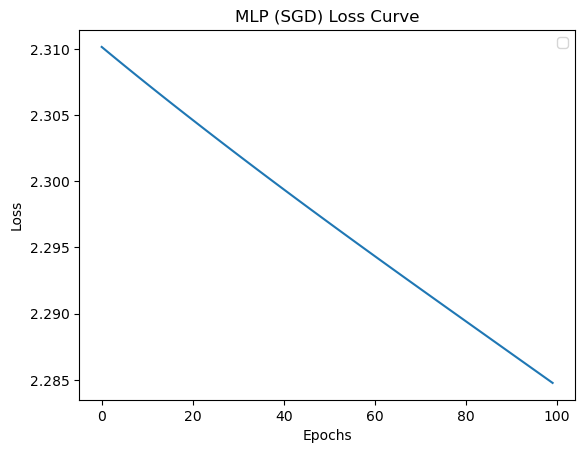

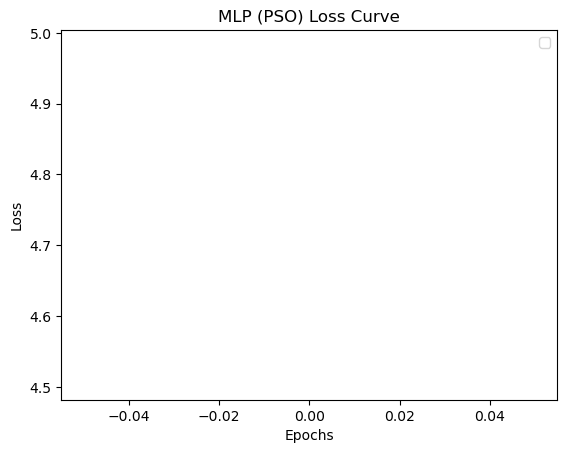

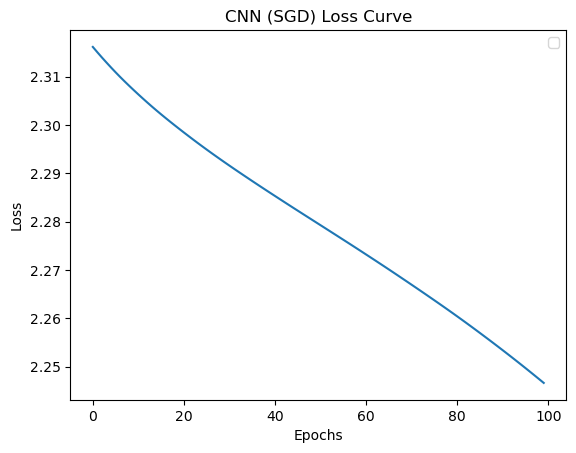

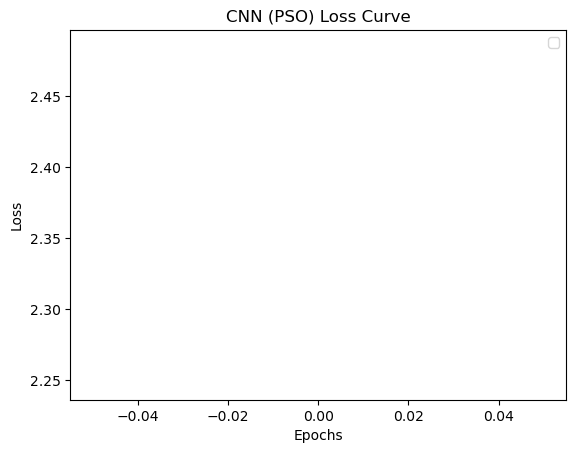

In [15]:
plot_loss_curves(mlp_sgd_loss, 'MLP (SGD) Loss Curve')
plot_loss_curves(mlp_pso_cost, 'MLP (PSO) Loss Curve')
plot_loss_curves(cnn_sgd_loss, 'CNN (SGD) Loss Curve')
plot_loss_curves(cnn_pso_cost, 'CNN (PSO) Loss Curve')

In [16]:
# Compute test accuracy
mlp_sgd_test_acc = evaluate_accuracy(mlp_model_SGD, X_test, y_test)
cnn_sgd_test_acc = evaluate_accuracy(cnn_model_SGD, X_test.unsqueeze(1), y_test)

mlp_pso_test_acc = evaluate_accuracy(mlp_model_PSO, X_test, y_test)
cnn_pso_test_acc = evaluate_accuracy(cnn_model_PSO, X_test.unsqueeze(1), y_test)

print(f"MLP Test Accuracy (SGD): {mlp_sgd_test_acc:.4f}")
print(f"CNN Test Accuracy (SGD): {cnn_sgd_test_acc:.4f}")

print(f"MLP Test Accuracy (PSO): {mlp_pso_test_acc:.4f}")
print(f"CNN Test Accuracy (PSO): {cnn_pso_test_acc:.4f}")

MLP Test Accuracy (SGD): 0.1467
CNN Test Accuracy (SGD): 0.2056
MLP Test Accuracy (PSO): 0.0403
CNN Test Accuracy (PSO): 0.0993
